In [1]:
# Set Directories

MAIN_DIR = "/gws/nopw/j04/ai4er/users/trr26/earthquake-predictability"
DATA_DIR = "/gws/nopw/j04/ai4er/users/trr26/earthquake-predictability/data/gtc_quakes_data"
p4581_FILE_PATH = f"{DATA_DIR}/labquakes/Marone/p4581/p4581.txt"

# Imports

import os
import random
import sys
from math import sqrt

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

sys.path.append(MAIN_DIR)
import utils

In [2]:
with open(p4581_FILE_PATH, "r") as file:
    df = pd.read_csv(file, delim_whitespace=True, skiprows=4)

df.columns = [
    "id",
    "lp_disp",
    "shr_stress",
    "nor_disp",
    "nor_stress",
    "time",
    "sync",
    "samp_freq",
]

df = df.drop(["id"], axis=1)
df = df[["time"] + [col for col in df.columns if col != "time"]]

df.head()

,time,lp_disp,shr_stress,nor_disp,nor_stress,sync,samp_freq
0,1.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
1,2.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
2,3.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
3,4.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
4,5.0,0.0,0.0,-0.0,1.000000e-18,3.29855,1


In [3]:
# Analyses the different recording frequencies in the dataset

df["samp_freq"].value_counts().sort_index().reset_index().rename(
    columns={"index": "Sample Frequency", "samp_freq": "Frequency"}
)

,Frequency,count
0,1,1640
1,1000,3477000


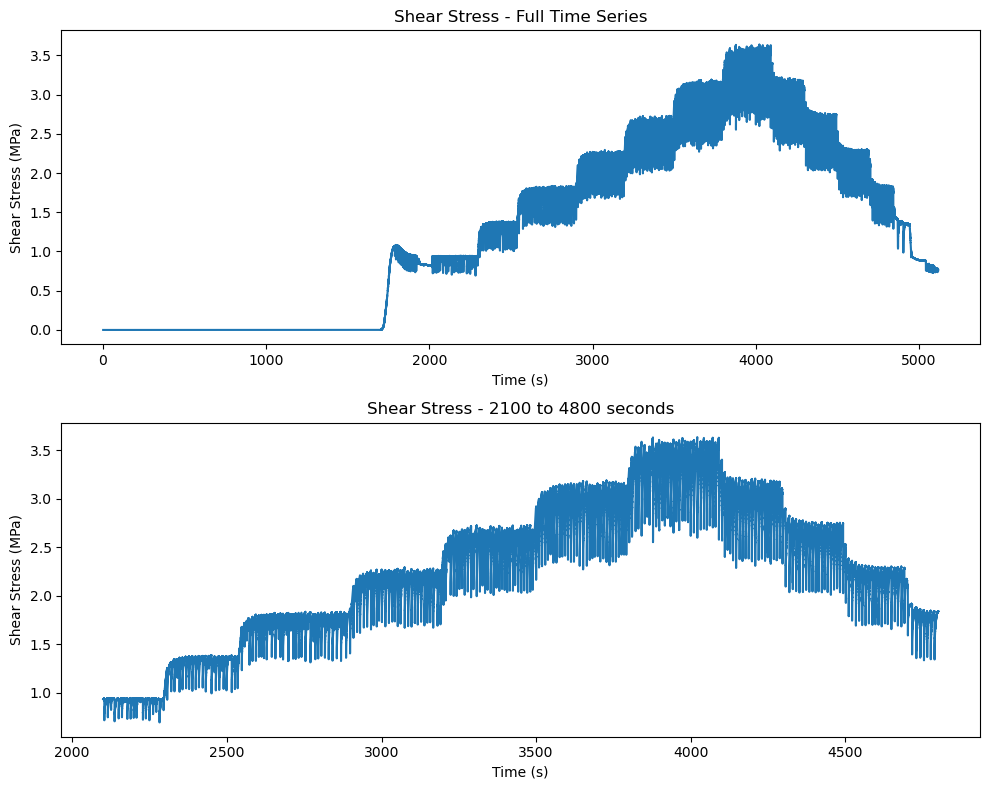

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot all data
axes[0].plot(df["time"], df["shr_stress"])
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Shear Stress (MPa)")
axes[0].set_title("Shear Stress - Full Time Series")

# Trim
axes[1].plot(
    df[(df["time"] >= 2100) & (df["time"] < 4800)]["time"],
    df[(df["time"] >= 2100) & (df["time"] < 4800)]["shr_stress"],
)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Shear Stress (MPa)")
axes[1].set_title("Shear Stress - 2100 to 4800 seconds")

plt.tight_layout()
plt.show()

In [5]:
# Trims the data frame, removing irrelevant data

df = df[(df["time"] >= 2100) & (df["time"] < 4800)]
df.reset_index(drop=True, inplace=True)
df.head()

,time,lp_disp,shr_stress,nor_disp,nor_stress,sync,samp_freq
0,2100.0,3057.39,0.932700,2072.64,2.01227,3.29853,1000
1,2100.0,3060.88,0.932965,2072.54,2.01242,3.29851,1000
2,2100.0,3062.33,0.933241,2072.53,2.01058,3.29855,1000
3,2100.0,3057.01,0.932987,2072.59,2.01066,3.29853,1000
4,2100.0,3062.42,0.933346,2072.62,2.01216,3.29854,1000


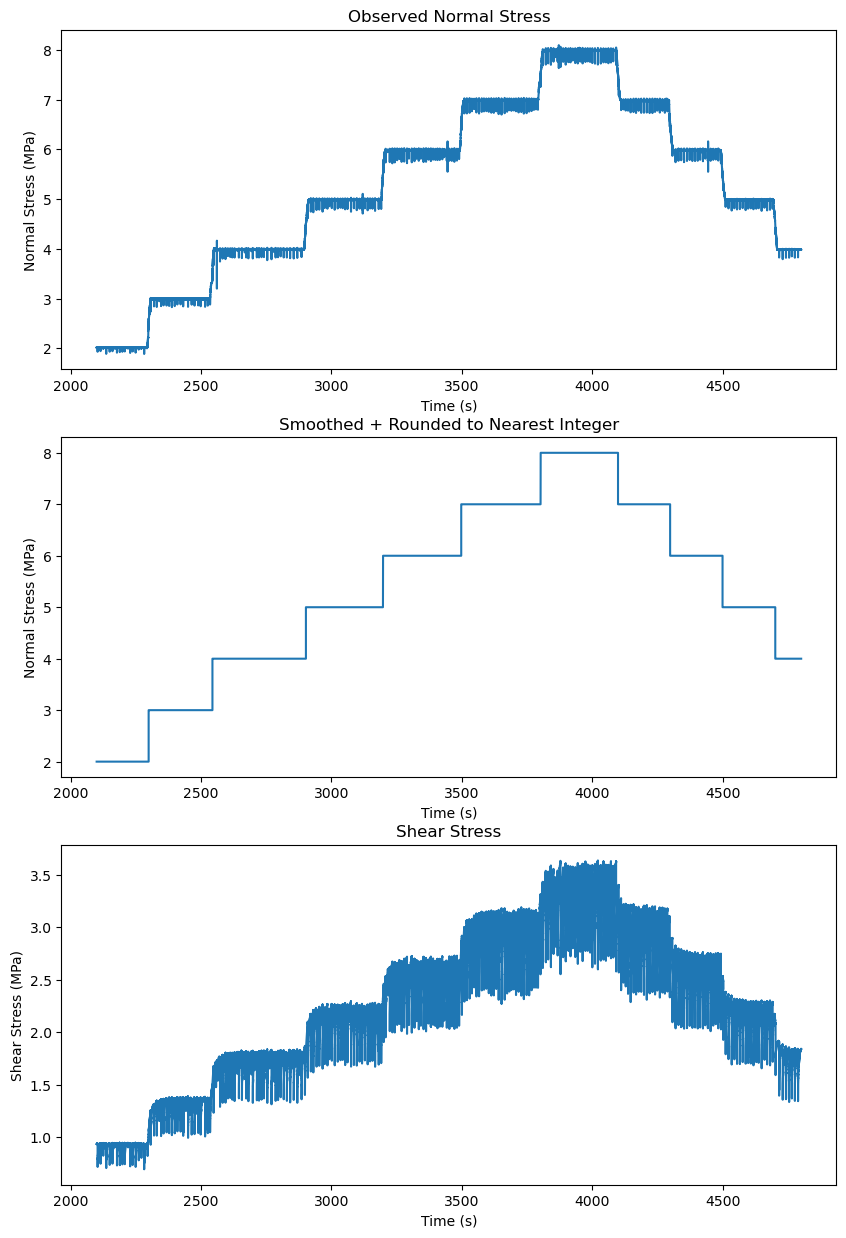

In [6]:
# Smooths the normal stress time series then rounds to the nearest integer
# to get estimate for "target" normal stress

window_size = 100
df["smoothed_nor_stress"] = (
    df["nor_stress"].rolling(window_size, center=True).mean()
)
df["target_nor_stress"] = (
    df["smoothed_nor_stress"].fillna(0).round().astype(int)
)

# Trims data
df = df[df["target_nor_stress"] != 0]

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot 1
axes[0].plot(df["time"], df["nor_stress"])
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Normal Stress (MPa)")
axes[0].set_title("Observed Normal Stress")

# Plot 2
axes[1].plot(df["time"], df["target_nor_stress"])
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Normal Stress (MPa)")
axes[1].set_title("Smoothed + Rounded to Nearest Integer")

# Plot 3
axes[2].plot(df["time"], df["shr_stress"])
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Shear Stress (MPa)")
axes[2].set_title("Shear Stress")

plt.show()

In [7]:
# Find the indices where target_nor_stress changes
segment_indices = np.where(df["target_nor_stress"].diff() != 0)[0]

# Segment the dataframe based on the indices
segments = np.split(df, segment_indices)

/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
# Create a dropdown widget with segment indices as options
segment_dropdown = widgets.Dropdown(
    options=list(range(1, len(segments))),
    description="Segment:",
    value=7,  # Defaults on the segment used by Laurenti et al.
)


def update_plot(segment_index):
    num_columns = (
        len(segments[segment_index].columns) - 1
    )  # Exclude the 'time' column
    num_rows = (
        num_columns + 1
    ) // 2  # Calculate the number of rows for subplots

    fig, axes = plt.subplots(
        num_rows, 2, figsize=(15, 4 * num_rows)
    )  # Adjust the figsize here

    for i, column in enumerate(
        segments[segment_index].columns[1:]
    ):  # Exclude the 'time' column
        row = i // 2
        col = i % 2
        ax = axes[row, col] if num_rows > 1 else axes[col]

        ax.plot(
            segments[segment_index]["time"], segments[segment_index][column]
        )
        ax.set_xlabel("Time (s)")
        ax.set_title(column)

    plt.tight_layout()
    plt.show()


# Display the dropdown widget and plot
widgets.interact(update_plot, segment_index=segment_dropdown)

interactive(children=(Dropdown(description='Segment:', index=6, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), v…

<function __main__.update_plot(segment_index)>

In [9]:
def detrend_first_order_poly(x, y):
    p = np.polyfit(x, y, deg=1)
    y_det = y - (p[0] * x + p[1])
    return y_det

In [10]:
segment_dropdown = widgets.Dropdown(
    options=list(range(1, len(segments) + 1)),
    description="Segment:",
    value=7,  # Defaults on the segment used by Laurenti et al.
)


def update_plot(segment_index):
    x = segments[segment_index]["time"]
    y = segments[segment_index]["shr_stress"]
    y_det = detrend_first_order_poly(x, y)

    fig, axes = plt.subplots(2, 1, figsize=(10, 7))
    axes[0].plot(x, y)
    axes[0].set_title("Observed")
    axes[1].plot(x, y_det)
    axes[1].set_title("Detrended")
    plt.show()


widgets.interact(update_plot, segment_index=segment_dropdown)

interactive(children=(Dropdown(description='Segment:', index=6, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

<function __main__.update_plot(segment_index)>

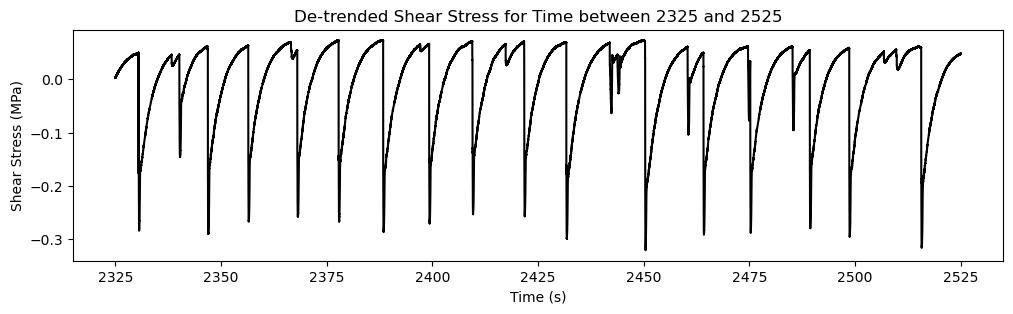

In [11]:
time_range = (df["time"] >= 2325) & (df["time"] <= 2525)

x = df.loc[time_range, "time"]
y = df.loc[time_range, "shr_stress"]
y_det = detrend_first_order_poly(x, y)

plt.figure(figsize=(12, 3))
plt.plot(x, y_det, "-k")
plt.xlabel("Time (s)")
plt.ylabel("Shear Stress (MPa)")
plt.title("De-trended Shear Stress for Time between 2325 and 2525")
plt.show()